# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import os

In [3]:
folder_path = r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\EEA Winter Project\Dataset"
os.listdir(folder_path)

['fruits-360_100x100',
 'fruits-360_3-body-problem',
 'fruits-360_dataset_meta',
 'fruits-360_multi',
 'fruits-360_original-size']

In [4]:
#Working on only the fruits-360_100x100 folder

def get_fruits360_split(base_dir, split="Training"):

    # For finding  the 100x100 dataset folder
    dataset_100x100 = None
    for item in os.listdir(base_dir):
        full_path = os.path.join(base_dir, item)
        if os.path.isdir(full_path) and "100x100" in item:
            dataset_100x100 = full_path
            break

    if dataset_100x100 is None:
        raise FileNotFoundError("Could not find fruits-360_100x100 folder")

    # Accessing inner folder in path
    inner_dirs = [os.path.join(dataset_100x100, d) for d in os.listdir(dataset_100x100) if os.path.isdir(os.path.join(dataset_100x100, d))]
    fruits360_root = inner_dirs[0]

    # Selecting training and testing folder
    split_dir = os.path.join(fruits360_root, split)

    return split_dir


In [5]:
base_dir = r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\EEA Winter Project\Dataset"

train_dir = get_fruits360_split(base_dir, split="Training")
test_dir  = get_fruits360_split(base_dir, split="Test")

print(train_dir)
print(os.listdir(train_dir)[:5])
print(test_dir)
print(os.listdir(test_dir)[:5])


C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\EEA Winter Project\Dataset\fruits-360_100x100\fruits-360\Training
['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14']
C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\EEA Winter Project\Dataset\fruits-360_100x100\fruits-360\Test
['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14']


In [6]:
import cv2

def get_color_features(img_bgr):
    # Converting BGR to HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]

    mean_h = np.mean(h) # Maan hue
    std_h = np.std(h)  # Standard deviation of hue

    mean_s = np.mean(s) # Man saturation
    std_s = np.std(s) # Standard deviation of saturation

    mean_v = np.mean(v) # Mean value
    std_v = np.std(v) # Standard deviation of value

    color_features = np.array([mean_h, std_h, mean_s, std_s, mean_v, std_v], dtype=np.float32) # storing them as array of color features

    return color_features






        


In [7]:
def get_shape_features(gray_img):
    # Creating binary mask
    _, mask = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros(6, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea) # Finding the largest contour

    x, y, w, h = cv2.boundingRect(cnt)

    area = cv2.contourArea(cnt)
    
    # Calculating Extent
    if w*h != 0:
        extent = area / (w*h)
    else : 
        extent = 0
    
    # Calculating Aspect Ratio
    if h != 0 :  
        aspect_ratio = float(w) / h
    else :
        aspect_ratio = 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)

    # Calculating Solidity
    if hull_area != 0:
        solidity = area / hull_area
    else :
        solidity = 0

    perimeter = cv2.arcLength(cnt, True)
    
    # Calculating Circularity
    if perimeter != 0:
        circularity = (4*np.pi*area)/(perimeter**2)
    else:
        circularity = 0

    moments = cv2.moments(cnt)
    hu_moments = cv2.HuMoments(moments).flatten()

    phi1 = hu_moments[0] # Shape spread
    phi2 = hu_moments[1] # Shape variance

    shape_features = np.array([extent, aspect_ratio, solidity, circularity, phi1, phi2], dtype=np.float32)

    return shape_features

In [8]:
def get_lbp(img):
    h, w = img.shape
    lbp = np.zeros((h - 2, w - 2), dtype=np.uint8)

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            c = img[i, j]
            code = 0

            code |= (img[i-1,j-1] >= c) << 7
            code |= (img[i-1,j] >= c) << 6
            code |= (img[i-1,j+1] >= c) << 5
            code |= (img[i,j+1] >= c) << 4
            code |= (img[i+1,j+1] >= c) << 3
            code |= (img[i+1,j] >= c) << 2
            code |= (img[i+1,j-1] >= c) << 1
            code |= (img[i,j-1] >= c) << 0

            lbp[i-1, j-1] = code

    return lbp

In [9]:
# Creating Custom Dataset
class Fruits_360_Dataset(Dataset):

    def __init__(self, base_dir):
        # Loading Data
        self.base_dir = base_dir
        self.img_paths = []
        self.labels = []

        # Making different classes for different fruits
        for fruit in os.listdir(self.base_dir):
            fruit_path = os.path.join(base_dir, fruit)
            if os.path.isdir(fruit_path):
                self.labels.append(fruit)

        self.classes = sorted(self.labels)
        
        #Assigning index to classes

        self.class_labels_idx = {name: idx for idx, name in enumerate(self.classes)}

        self.samples = []

        for fruit in self.classes:
            fruit_path = os.path.join(self.base_dir, fruit)

            for img_name in os.listdir(fruit_path):
                img_path = os.path.join(fruit_path, img_name)
                self.samples.append((img_path, fruit))

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, index):
        # Getting image path and label
        img_path, label = self.samples[index]

        img = cv2.imread(img_path)

        #Checking temporarily
        
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        color_features = get_color_features(img)
        shape_features = get_shape_features(gray_img)

        #Creating a feature vector as is expected by standard

        features = np.concatenate([color_features, shape_features])
        label_idx = self.class_labels_idx[label]

        lbp_img = get_lbp(gray_img)


        return {
            "image": img,
            "lbp": lbp_img,
            "color_features": color_features,
            "shape_features": shape_features,
            "label": label_idx,
            "labels": self.class_labels_idx
        }

In [10]:
main_dir = get_fruits360_split(base_dir)
dataset = Fruits_360_Dataset(main_dir)

for i in range(5):
    sample = dataset[i]

    img = sample["image"]
    lbp = sample["lbp"]
    color_f = sample["color_features"]
    shape_f = sample["shape_features"]
    label_idx = sample["label"]
    dictionary = sample["labels"]

    print(f"Sample {i}")
    print("Image shape:", img.shape)
    print("LBP shape:", lbp.shape)
    print("Color features:", color_f)
    print("Shape features:", shape_f)
    print("Label idx:", label_idx)

print("Dictonary :", dictionary )


Sample 0
Image shape: (100, 100, 3)
LBP shape: (98, 98)
Color features: [ 10.3157    28.434052 134.31      90.26303  164.3471    64.10116 ]
Shape features: [7.9311109e-01 1.1111112e+00 9.7687149e-01 8.1424397e-01 1.6141827e-01
 4.8689477e-04]
Label idx: 0
Sample 1
Image shape: (100, 100, 3)
LBP shape: (98, 98)
Color features: [ 10.8169    17.622389  99.2991    68.640335 179.2186    54.479298]
Shape features: [8.1909090e-01 1.1363636e+00 9.9119914e-01 8.9046603e-01 1.6089338e-01
 3.8684678e-04]
Label idx: 0
Sample 2
Image shape: (100, 100, 3)
LBP shape: (98, 98)
Color features: [ 11.1305    18.667053  97.813     69.28195  180.2215    55.012486]
Shape features: [8.0721593e-01 1.1363636e+00 9.8941433e-01 8.7810957e-01 1.6109513e-01
 4.5476423e-04]
Label idx: 0
Sample 3
Image shape: (100, 100, 3)
LBP shape: (98, 98)
Color features: [ 11.1404    18.88193   98.7349    68.6852   179.4561    54.627937]
Shape features: [8.1704545e-01 1.1363636e+00 9.9104065e-01 8.9015675e-01 1.6082342e-01
 3.80

In [11]:
from torch.utils.data import DataLoader

loader = DataLoader(
    dataset,
    batch_size=1, 
    shuffle=True
)

sample = next(iter(loader))
print(sample.keys())


dict_keys(['image', 'lbp', 'color_features', 'shape_features', 'label', 'labels'])


In [12]:
for k, v in sample.items():
    print(k, type(v))


image <class 'torch.Tensor'>
lbp <class 'torch.Tensor'>
color_features <class 'torch.Tensor'>
shape_features <class 'torch.Tensor'>
label <class 'torch.Tensor'>
labels <class 'dict'>


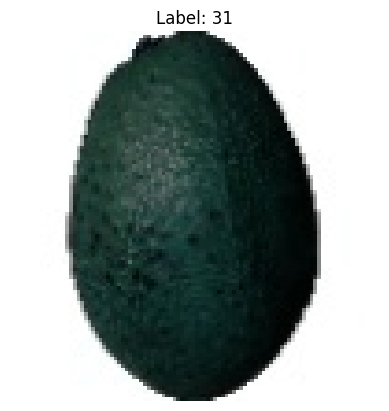

In [17]:
import matplotlib.pyplot as plt


plt.imshow(sample['image'][0]   )
plt.axis('off')
plt.title(f"Label: {sample['label'].item()}")
plt.show()


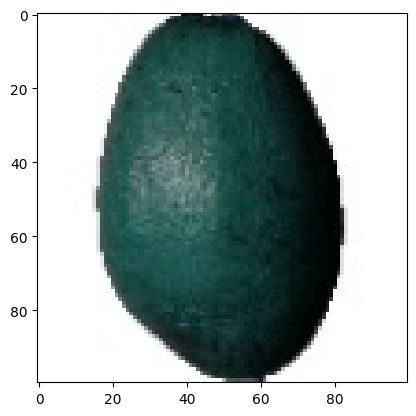

In [23]:
compare = cv2.imread(r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\EEA Winter Project\Dataset\fruits-360_100x100\fruits-360\Training\Avocado 1\0_100.jpg")

plt.imshow(compare)